# CNN Cancer Detection Kaggle Mini Project

**DTSA 5511**

**10/11/2023**

**Garrett Bainwol**

[Github Repository link](https://github.com/gbainwol/DTSA5511_CNN_CANCER_KAGGLE_PROJECT)

# **Overview**

The main goal of this project is to develop an algorithm that can recognize metastatic cancer in small picture patches extracted from larger digital pathology scans. To better comprehend the information provided in this competition, we shall investigate it. The goal of the subsequent convolutional neural network models is to identify cancerous(1) and non-cancerous(0) cells. Patients will be able to receive life-saving treatments more quickly thanks to improved and quicker cancer detection. Two models, one with and one without hyperparameter adjustment, will be built. We will make some recommendations on ways to make the models better in next research.

In [1]:
#Library imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
import shutil

#Image processing
from skimage.transform import rotate
from skimage import io
import cv2 as cv

#Model deployment
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
#Directories
os.listdir('../input/histopathologic-cancer-detection/')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
# Number of images in training and test set 
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

220025
57458


In [4]:
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
test_data = pd.DataFrame({'id':os.listdir(test_path)})

# removing this training image because it caused a training error previously
train_data[train_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this training image because it's not visible
train_data[train_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']

print(train_data.shape)

(220025, 2)


In [5]:
# declare constants for reproduciblity
RANDOM_STATE = 101

# Exploratory Data Analysis

In [6]:
train_data.sample(10)

,id,label
211600,21fe8f7140df7518be4a2124cd42be445b0f856f,0
20307,a15a24809e85175343d8aca8060cf2ec88391375,1
70595,a224403d9fc3340f9170c15f2a47530a3dbccaf5,0
210406,9c4841aa2373a9865f7073c0fd2f0209422b5795,1
201768,0ded2e7ecce4cfd012dda91a6a34a3058b603247,1
25550,82738e371d8efb1a9d944396c2a589314f5e4c5e,0
103016,a07db7c5cef3b3ea17471b5ea5735b58fe4c634c,0
78258,846c955280a3ffb1fc36e187bbd5a0228a8e7b73,0
219497,68af5e052aa022b965c65528bcb22a293de203a8,0
136265,6c21640f5dd48601969427dacf7ecc35c6d9dcbe,0


In [7]:
test_data.sample(10)

,id
31251,d2cfb386caff7507319634c55ed375d36456cb77.tif
41417,9a22ef153ca916f621bce93664c0254bb031ba3e.tif
44900,7191cd62d1ee100a2ddf3bcbf06a71fa65b507e2.tif
6962,262c8fa8fd41caffe767629e6a462e05bc3148da.tif
17516,fd59ed1fdb19372512719073e1ef25d58edf8bc7.tif
23389,f7f34ad3bbad37603647168bd00ff7ee42433d76.tif
34344,952e399a8aff0a267acb3e858f7bd981c72f1ed1.tif
15530,e110638582350fc11ed7e401c9ce08c10e0fc725.tif
13130,43c472d510fcb9bc0f2360b52eba67e09dea71f4.tif
3830,f62c14d27a069270d695942a5285f9c2384ed8d9.tif


# Data Visualizations

We can observe from the training data visualizations that the split between **cancerous(1)** and **non-cancerous(0)** tissue is roughly 60/40, making for a reasonably balanced dataset for predictions. We should be able to create a model that is somewhat accurate given that we are using thousands of photos.

0    130908
1     89117
Name: label, dtype: int64


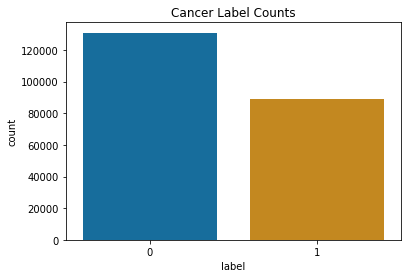

In [8]:
print(train_data['label'].value_counts())
sns.countplot(x=train_data['label'], palette='colorblind').set(title='Cancer Label Counts');

<AxesSubplot:title={'center':'Category Images'}, ylabel='label'>

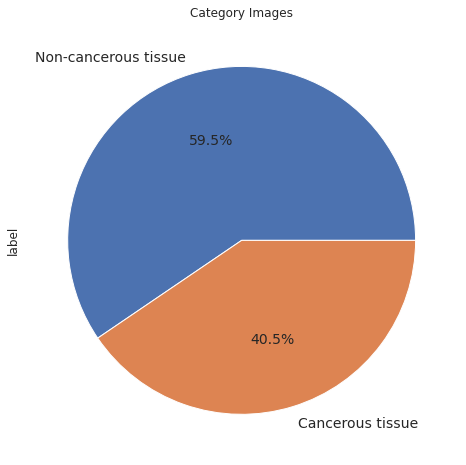

In [9]:
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(train_data['label'].replace(0,'Non-cancerous tissue').replace(1,'Cancerous tissue').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Category Images',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

Here are a few examples of training data images. The average person would not be able to tell if these photos are cancerous(1) or not by simply looking at them. Each image's correct label is displayed beneath it.

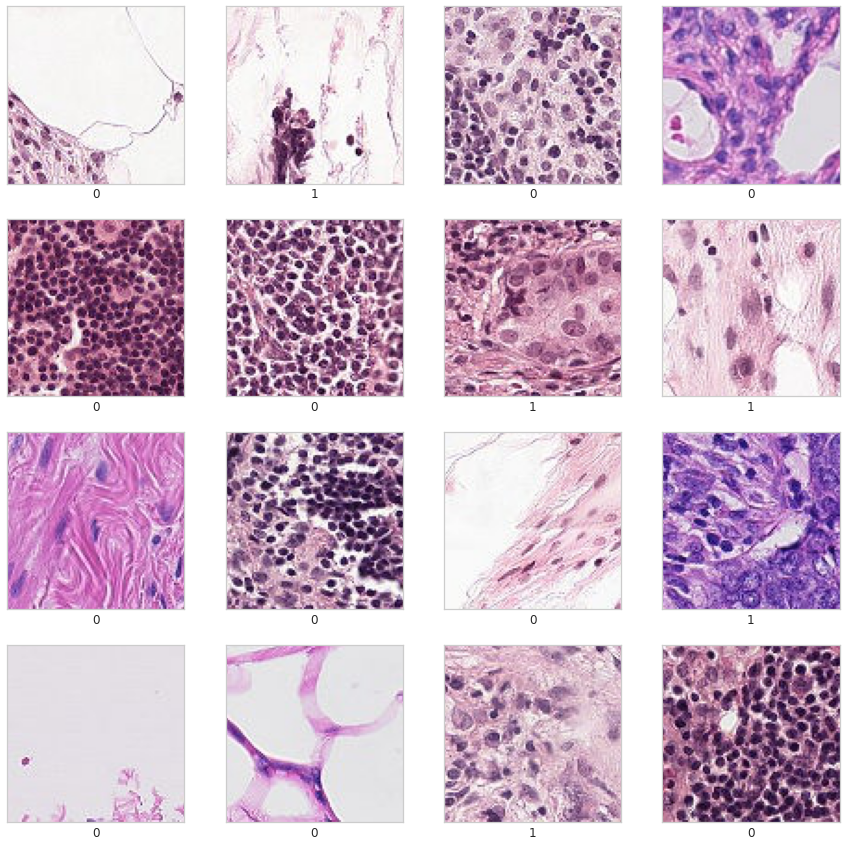

In [10]:
#Image Visualisations
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    file = str(train_path + train_data.id[i] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel = train_data.label[i]);

**Data Preprocessing**

The training set contained no missing data.Two photographs in the collection, nevertheless, were causing problems.Those were removed.

In order to prevent the model from learning based on the picture ordering or pattern of input, which can have implications for the model training, we shall **shuffle** the image data. To enhance model building, we will additionally divide the data into training and validation sets. We will divide the pixels by 255.0 to normalize them during training, which should aid in data processing and model training.

# Model Architecture

The Keras library will be used to operate a convolutional neural network (CNN). While the second model will be run with them, the first model will be run without them.

In our CNN model, the network will comprise two convolutional layers, followed by a MaxPool layer, and this process will be repeated n times. We will specifically build a very straightforward model with two (n=2) of these clusters. To put it another way, our model will go input --> Conv2D --> MaxPool --> Conv2D --> MaxPool --> Flatten --> Sigmoid-activated output.

model 1:

- Normalize images pre-training (image/255)
- Output layer activation (sigmoid)


Second model contains all the first model parameters, but we also add:

- Dropout (0.1)
- Batch Normalization
- Optimization (Adam)
- Learning rate (0.0001)
- Hidden layer activations (ReLU)


Let's discuss what each parameter will do to the model before we begin with the models. The first and second models will both utilize numbers 1 and 2, whereas the second and final models will use numbers 3 to 5.


#### Normalize images : 
- In order to normalize the data and have values between 0 and 1, this will divide each pixel in the image by 255.

#### Output layer activation : 
- Since we are dealing with binary data, we will employ a sigmoid activation function on the output layer.

#### Dropout : 
- The model will be regularized by utilizing a smaller number of weights for each training run when dropout is set to 0.1, which will randomly select some weights and set them to equal 0.

#### Optimization :
- In order to optimize the model, which effectively simulates momentum for gradient and gradient-squared, we will apply adaptive moment estimation (Adam).

#### Learning rate: 
- In order to help the gradient descent process, we will set our learning rate to 0.0001. This will make it less likely that the model will hopefully exceed the global minimum as it learns.
#### Hidden layer activations: 
- Our hidden layer activation function will be rectified linear regression (ReLU), which will improve model convergence, prevent saturation, and require less processing resources.

In order to further aid reduce variation, we will also employ very large batch sizes, set at 256. In the end, we will train our two models using 10 iterations. In addition to using binary cross-entropy as our loss function, we will also evaluate the model's performance using accuracy and the ROC-AUC curve.



In [11]:
# set model constants
BATCH_SIZE = 256

In [12]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [13]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [14]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 187022 validated image filenames belonging to 2 classes.


In [15]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))  

Found 33003 validated image filenames belonging to 2 classes.


In [16]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

**Model 1**

In [17]:
# set ROC AUC as metric
ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():
    
    #model design
    model_one = Sequential()
    
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(AveragePooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))
    
    #model input size
    model_one.build(input_shape=(BATCH_SIZE, 64, 64, 3))        # original image = (96, 96, 3) 
    
    #compiling
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
model_one.summary()

2022-11-23 23:42:10.905602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:10.906612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:11.241858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:11.242858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:11.243691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (256, 30, 30, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (256, 26, 26, 32)         9248      
_________________________________________________________________
average_pooling2d (AveragePo (256, 13, 13, 32)         0         
_________________________________________________________________
flatten (Flatten)            (256, 5408)               0

ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:11.246378: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 23:42:11.498847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:11.499727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 23:42:11.500574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

In [18]:
EPOCHS = 10

# train the model
history_model_one = model_one.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-23 23:42:18.400140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-23 23:42:23.256904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


731/731 [==============================] - 1582s 2s/step - loss: 0.5764 - accuracy: 0.7111 - auc: 0.7602 - val_loss: 0.5542 - val_accuracy: 0.7215 - val_auc: 0.8092
Epoch 2/10
731/731 [==============================] - 538s 736ms/step - loss: 0.5293 - accuracy: 0.7498 - auc: 0.8067 - val_loss: 0.4954 - val_accuracy: 0.7715 - val_auc: 0.8371
Epoch 3/10
731/731 [==============================] - 437s 597ms/step - loss: 0.5071 - accuracy: 0.7622 - auc: 0.8250 - val_loss: 0.4803 - val_accuracy: 0.7804 - val_auc: 0.8481
Epoch 4/10
731/731 [==============================] - 414s 567ms/step - loss: 0.4915 - accuracy: 0.7720 - auc: 0.8367 - val_loss: 0.4780 - val_accuracy: 0.7841 - val_auc: 0.8526
Epoch 5/10
731/731 [==============================] - 439s 600ms/step - loss: 0.4786 - accuracy: 0.7795 - auc: 0.8456 - val_loss: 0.5007 - val_accuracy: 0.7652 - val_auc: 0.8556
Epoch 6/10
731/731 [==============================] - 427s 584ms/step - loss: 0.4689 - accuracy: 0.7857 - auc: 0.8525 - val

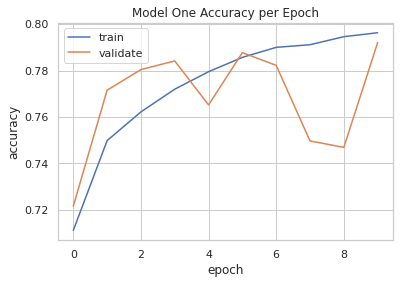

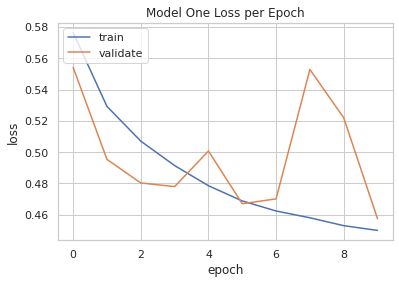

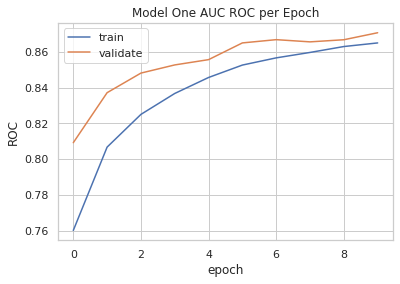

In [19]:
# plot model accuracy per epoch 
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model_one.history['auc'])
plt.plot(history_model_one.history['val_auc'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**Model build 2**

In [20]:
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    #create model
    model_two = Sequential()
    
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_two.add(MaxPooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(AveragePooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Flatten())
    model_two.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model_two.build(input_shape=(BATCH_SIZE, 64, 64, 3))       # original image = (96, 96, 3) 
    
    #compile
    adam_optimizer = Adam(learning_rate=0.0001)
    model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

#quick look at model
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (256, 62, 62, 16)         448       
_________________________________________________________________
conv2d_5 (Conv2D)            (256, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (256, 30, 30, 16)         0         
_________________________________________________________________
dropout (Dropout)            (256, 30, 30, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (256, 30, 30, 16)         64        
_________________________________________________________________
conv2d_6 (Conv2D)            (256, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (256, 26, 26, 32)        

In [21]:
EPOCHS = 10

# train model
history_model_two = model_two.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Epoch 1/10
731/731 [==============================] - 430s 586ms/step - loss: 0.4404 - accuracy: 0.7999 - auc_1: 0.8699 - val_loss: 0.7693 - val_accuracy: 0.7188 - val_auc_1: 0.8869
Epoch 2/10
731/731 [==============================] - 449s 614ms/step - loss: 0.3923 - accuracy: 0.8295 - auc_1: 0.8989 - val_loss: 0.5404 - val_accuracy: 0.7842 - val_auc_1: 0.8976
Epoch 3/10
731/731 [==============================] - 431s 589ms/step - loss: 0.3757 - accuracy: 0.8382 - auc_1: 0.9082 - val_loss: 0.6530 - val_accuracy: 0.7717 - val_auc_1: 0.8838
Epoch 4/10
731/731 [==============================] - 429s 587ms/step - loss: 0.3595 - accuracy: 0.8459 - auc_1: 0.9168 - val_loss: 0.4273 - val_accuracy: 0.8313 - val_auc_1: 0.9116
Epoch 5/10
731/731 [==============================] - 443s 605ms/step - loss: 0.3426 - accuracy: 0.8538 - auc_1: 0.9250 - val_loss: 0.3810 - val_accuracy: 0.8436 - val_auc_1: 0.9272
Epoch 6/10
731/731 [==============================] - 442s 604ms/step - loss: 0.3272 - acc

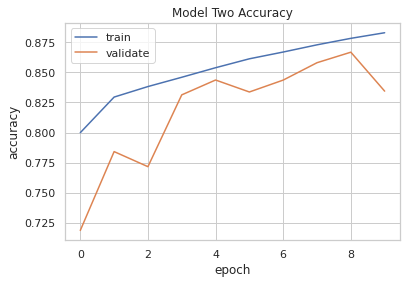

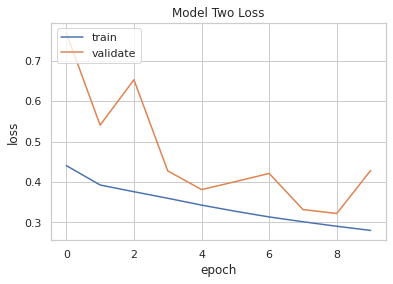

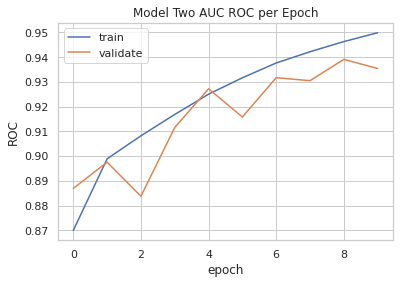

In [22]:
# graph loss
plt.plot(history_model_two.history['accuracy'])
plt.plot(history_model_two.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_two.history['loss'])
plt.plot(history_model_two.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model_two.history['auc_1'])
plt.plot(history_model_two.history['val_auc_1'])
plt.title('Model Two AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();


In [23]:
# preparing test data
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [24]:
#creating predictions

predictions = model_two.predict(test_generator, verbose=1)

57458/57458 [==============================] - 514s 9ms/step


In [25]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


In [26]:
submission_df['label'].value_counts()

0    30543
1    26915
Name: label, dtype: int64

<AxesSubplot:title={'center':'Submission Image Classification'}, ylabel='label'>

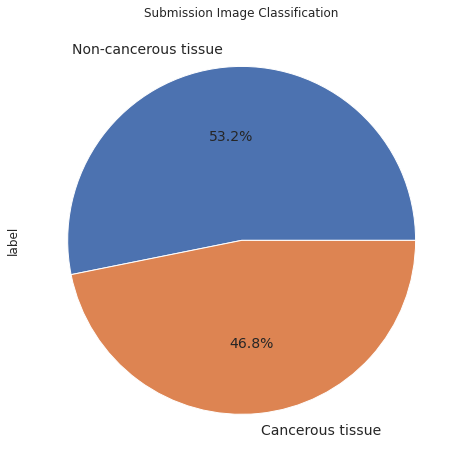

In [27]:
#Submission label percentage
sns.set(style='whitegrid')
pie_chart=pd.DataFrame(submission_df['label'].replace(0,'Non-cancerous tissue').replace(1,'Cancerous tissue').value_counts())
pie_chart.reset_index(inplace=True)
pie_chart.plot(kind='pie', title='Submission Image Classification',y = 'label', 
             autopct='%1.1f%%', shadow=False, labels=pie_chart['index'], legend = False, fontsize=14, figsize=(18,8))

In [28]:
#Competition Submission
submission_df.to_csv('submission.csv', index=False)



#### You can see how each model performed with the training and validation sets from the plots and diagrams above. We can observe that model two performed marginally better than model one, and the hyperparameter adjustment was responsible for this. 

## **Conclusion**
Overall, the model was able to make reasonably accurate predictions. We could only create a basic CNN network due to time and memory limitations.
Many different things could be done to improve the models. Training the model using enhanced photos is a sensible concept. 
Only the photos were normalized at the preprocessing stage. To help the model learn more examples of how images might be molded, you could normalize, flip, zoom in/out, stretch, rotate, etc. with the photos.The model might be able to learn more effectively with additional epochs. However, it's crucial that we avoid overfitting the data by overtraining it. We also didn't use more epochs because this project is just a demonstration. We are certain that these are worthwhile steps to take in another notebook, while it is difficult to predict which modification to the notebook would yield much better results without actually executing it and running the models.